In [1]:
#Importing necessary libraries
import cv2 #For accessing Camera
import numpy as np #Array
import os #To create files
from matplotlib import pyplot as plt #To plot
import mediapipe as mp #To draw hand coordinates
from keras.models import load_model #Used to load the saved model
from sklearn.model_selection import train_test_split #Split data into train and testing
from tensorflow.keras.utils import to_categorical #Labelling into categories
from tensorflow.keras.models import Sequential # Used in model making
from tensorflow.keras.layers import LSTM, Dense # Used in model making 
from tensorflow.keras.callbacks import TensorBoard #To visualize the graphs for the model
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score #Check Accuracy of our model

In [2]:
#Functions to detect, plot and draw coordinates for Left and Right Hands
#Referred documentation : https://google.github.io/mediapipe/solutions/holistic.html

#Build Keypoints
mp_holistic = mp.solutions.holistic #get hand coordinates
mp_drawing = mp.solutions.drawing_utils #draw those coordinates

#endianness is the order or sequence of bytes of a word of digital data in computer memory
#OpenCV uses BGR colours whereas Mediapipe uses RGB Colours for Prediction of Hand Coordinates
def mp_detect(image, model): #Make Colour Conversion, make image non-writable, predict, again back to image writable and finally colour conversion back to orginal
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                 
    results = model.process(image)
    image.flags.writeable = True     
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

def draw_landmarks(image, results): #Drawing Landmarks and Hand Connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    
def draw_styled_landmarks(image, results): #Style Landmarks and Connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))             
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
    
def Hand_points(results): #Extract Keypoints 
    #Getting the coordinates in x,y and z direction and using flatten to convert array into single dimension
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

In [3]:
#This Cell is for deciding or defining the parameters
DATA_PATH = os.path.join('Final_Submission_2_50') #Create a folder

#Array of Sign Detections Symbols used
actions = np.array(['Hello','Okay','Peace','Good','Bad','You','Me','Cancel', 'Break'])
no_sequences = 50 #Number of videos, so frames = 50*30 = 1500
sequence_length = 30 #Number of frames in a video

for i in actions: #Iterate through number of actions 
    for j in range(no_sequences): #Iterate through number of videos
        try: 
            os.makedirs(os.path.join(DATA_PATH, i, str(j))) #Store them in folders
        except: 
            print('Error creating folder in ', i, j, 'iteration') #Check whether the folder already exists, if yes then pass on
            pass 

In [4]:
#This Cell is for Collection of the Data through CV2 and then saving them to a Folder and labelling them
cam = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic: # Set mediapipe model
    for action in actions: #Iterate through actions
        for sequence in range(no_sequences): #Iterate through no. of videos
            for frame_num in range(sequence_length): #Iterate through no. of frames
                ret, frame = cam.read() #Collect Frame
                image, results = mp_detect(frame, holistic) #Detect the hand coordinates
                draw_styled_landmarks(image, results) # Draw landmarks
                
                #Applying a logic to wait for collection of data
                if frame_num == 0: #For initially starting collection of a particular action
                    cv2.putText(image, 'Collecting Data for {} Video Number {}'.format(action, sequence), (150,25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (242, 48, 103), 1, cv2.LINE_AA)
                    cv2.imshow('DATA COLLECTION WINDOW', image) # Display the resulting frame
                    cv2.waitKey(1)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (150,25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (242, 48, 103), 1, cv2.LINE_AA)
                    cv2.imshow('DATA COLLECTION WINDOW', image) # Display the resulting frame
                keypoints = Hand_points(results) #Call function Hand_points and store the result
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num)) #Decide the folder to save the frame or result
                np.save(npy_path, keypoints) #Save the result in the given folder path
                if cv2.waitKey(10) & 0xFF == ord('a'): #Wait time between data collection and press 'a' to skip that data for that iteration
                    break  #Back to new data collection for the same action                 
    cam.release() #Turn off the camera
    cv2.destroyAllWindows() #Turn of all the CV2 Windows
    
#Label the actions starting from 0 to n
label_map = {label:num for num, label in enumerate(actions)}
print(label_map) #Print the label    

{'Hello': 0, 'Okay': 1, 'Peace': 2, 'Good': 3, 'Bad': 4, 'You': 5, 'Me': 6, 'Cancel': 7, 'Break': 8}


In [5]:
#This Cell is for Appending or storing all the data in a single array
sqs, lbls = [], [] #Create empty list 
for i in actions: #Iterate thorugh actions
    for j in range(no_sequences): #Iterate through no. of videos
        temp = [] #Empty List
        for k in range(sequence_length): #Iterate through frames
                result = np.load(os.path.join(DATA_PATH, i, str(j), "{}.npy".format(k))) #Access the data saved on the path
                temp.append(result) #Save frames of an action 1 by 1
        sqs.append(temp) #Save those frames in a list 
        lbls.append(label_map[i]) #Save the list of an action to label list, for eg. hello, ty, etc.

In [6]:
#This cell is for Splitting the DATA and defining input and target for the model, later printing the shape of it respectively
#X is the attributes and Y is the target and then we split 50% of the data into train and testing 
X = np.array(sqs) #Attributes
y = to_categorical(lbls).astype(int) #Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5) #Splitting
print('Number of Data:', len(X), 'and Number of Target :', len(y))
print('Train Data :', X_train.shape,' and Train Target :',y_train.shape)
print('Test Data :', X_test.shape,' and Test Target :',y_test.shape) #126 is the number of coordinates of the hand

Number of Data: 450 and Number of Target : 450
Train Data : (225, 30, 126)  and Train Target : (225, 9)
Test Data : (225, 30, 126)  and Test Target : (225, 9)


In [9]:
log_dir = os.path.join('Logs') #Create Logs for the model
tb_callback = TensorBoard(log_dir=log_dir) #used for analyzing the Data flow graph and used to understand machine-learning models.
#Create LSTM Model and train it
#Sequential model is a linear stack of layers
model = Sequential() #A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(30,126))) #126 is the number of coordinates of the hand
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dense(64, activation='tanh')) #Generally ReLu Activation Function is preffered over 
model.add(Dense(32, activation='tanh')) 
model.add(Dense(actions.shape[0], activation='softmax')) #softmax as an activation function is helpful for amplifying error gradients
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy']) #Configures the model for training.
model.fit(X_train, y_train, epochs=500, callbacks=[tb_callback]) #Train the model

Epoch 1/500
8/8 [==============================] - 4s 92ms/step - loss: 2.0892 - categorical_accuracy: 0.2000
Epoch 2/500
8/8 [==============================] - 0s 24ms/step - loss: 1.8173 - categorical_accuracy: 0.3067
Epoch 3/500
8/8 [==============================] - 0s 25ms/step - loss: 1.6338 - categorical_accuracy: 0.3733
Epoch 4/500
8/8 [==============================] - 0s 24ms/step - loss: 1.5183 - categorical_accuracy: 0.3867
Epoch 5/500
8/8 [==============================] - 0s 26ms/step - loss: 1.4781 - categorical_accuracy: 0.3911
Epoch 6/500
8/8 [==============================] - 0s 24ms/step - loss: 1.4091 - categorical_accuracy: 0.4533
Epoch 7/500
8/8 [==============================] - 0s 24ms/step - loss: 1.2525 - categorical_accuracy: 0.5244
Epoch 8/500
8/8 [==============================] - 0s 24ms/step - loss: 1.1887 - categorical_accuracy: 0.5244
Epoch 9/500
8/8 [==============================] - 0s 26ms/step - loss: 1.3534 - categorical_accuracy: 0.4800
Epoch 10/5

In [10]:
model.summary() #Print the summary of the trained model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30, 64)            48896     
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 297       
Total params: 203,657
Trainable params: 203,657
Non-trainable params: 0
________________________________________________

In [13]:
#Check whether the Y_test and Predicted Target have the same class
res = model.predict(X_test) #Check the result for X_test data predicted in the model
print('Predicted Result :', actions[np.argmax(res[100])]) #Print the nth term of the predicted result
print('Actual Result :',actions[np.argmax(y_test[100])]) #Print the nth term of Y_test, if both are same, model is trained properly

Predicted Result : Me
Actual Result : Me


In [14]:
model.save('Final_Submission_2_50.h5') #Save our model

For Gesture - Hello :
 [[201   2]
 [  1  21]]
For Gesture - Okay :
 [[201   3]
 [  2  19]]
For Gesture - Peace :
 [[203   0]
 [  1  21]]
For Gesture - Good :
 [[195   1]
 [  0  29]]
For Gesture - Bad :
 [[197   0]
 [  1  27]]
For Gesture - You :
 [[196   1]
 [  1  27]]
For Gesture - Me :
 [[195   1]
 [  1  28]]
For Gesture - Cancel :
 [[203   1]
 [  1  20]]
For Gesture - Break :
 [[200   0]
 [  1  24]]

Total Accuracy : 0.96


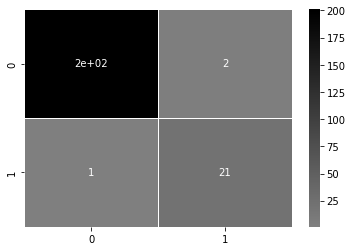

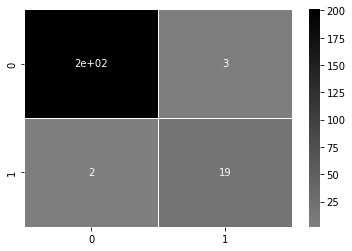

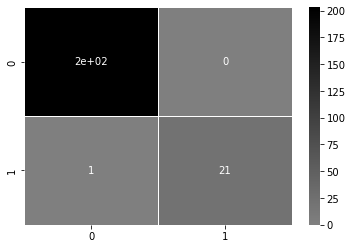

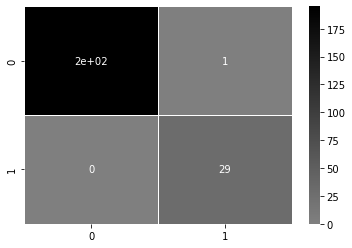

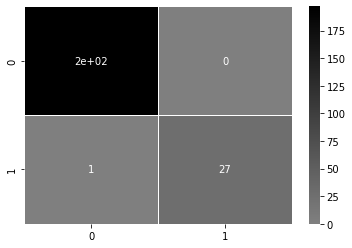

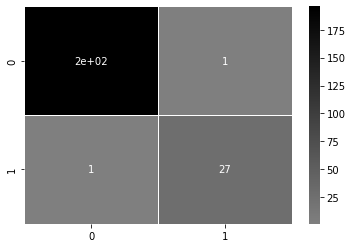

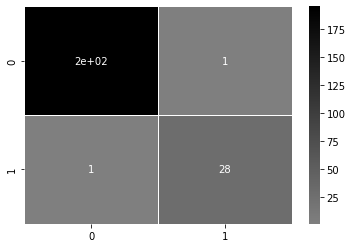

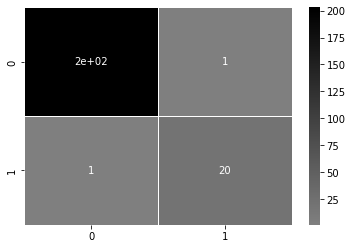

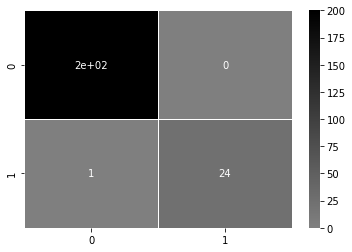

In [15]:
import seaborn as sns #Import for Heatmap
y_estimated = np.argmax(model.predict(X_test), axis=1).tolist() #Estimated Values for X_test Data which is Y_Test predicted
y_actual = np.argmax(y_test, axis=1).tolist() #Actual Values of Y_test which is Y_Test actual
cm = multilabel_confusion_matrix(y_actual, y_estimated) #Confusion Multilabled Matrix
for i in range(len(cm)) : #Iterate through Confusion Matrix of each Label
    print('For Gesture -', actions[i], ':\n',cm[i]) #Print Confusion Matrix for each label
    plt.figure(i) #Define a plot for Heamap
    ax = sns.heatmap(cm[i], cmap="binary", center=0, annot=True, linewidths=.5) #Print all the Heatmaps Orderwise
print('\nTotal Accuracy :',accuracy_score(y_estimated, y_actual)) #Print the Accuracy of the Model

In [17]:
#7 
model = load_model('Final_Submission_2_50.h5') #Call our model
colors = [(170,60,150), (117,245,16), (19,69,139), (255,0,0), (255,0,255), (16,117,245), (0,215,255), (0,0,255),  (185,218,255)] #BGR Colour Palletes for the Predicted Word

def probability_colours(res, actions, input_frame, colors): #Function to check the probability of the predicted word and increase/dexrease the size of the bar
    op = input_frame.copy() #Copies the input_frame dimensions in the output frame
    for i, j in enumerate(res): #Iterate through the predicted result
        cv2.rectangle(op, (0,60+i*40), (int(j*100), 90+i*40), colors[i], -1) #Increase or decrease the bar size according to the probability of prediction of the class
        cv2.putText(op, actions[i], (0, 85+i*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA) #Put the text on the left side
    return op #Return the output frame

sequence = [] #Empty List for Sequence - Number of frames in a video
sentence = [] #Empty List for all the Sentences
threshold = 0.8 #Threshold value for Prediction Result
cam = cv2.VideoCapture(0) #Turn on the Camera
with mp_holistic.Holistic(min_detection_confidence=0.9, min_tracking_confidence=0.9) as holistic: #Tracking 
    while cam.isOpened(): #Camera is opened
        ret, frame = cam.read() #Read frame by frame
        image, results = mp_detect(frame, holistic) #Processing the image by calling the function
        print(results) #Printing results for log
        draw_styled_landmarks(image, results) #Calling function
        keypoints = Hand_points(results) #Drawing handpoints
        sequence.append(keypoints) #Add the Hand_point result in the sequence
        sequence = sequence[-30:] #Taking the last 30 frames of the sequence
        if len(sequence) == 30: #Taken frames = 30 to start prediction
            res = model.predict(np.expand_dims(sequence, axis=0))[0] #Predicting the Class with the Gesture
            if res[np.argmax(res)] > threshold: #Checking if the result is above the threshold value
                if len(sentence) > 0: #See if sentence length is greater than 0
                    if actions[np.argmax(res)] != sentence[-1]: #Checking if the Current Action is not the previous one
                        sentence.append(actions[np.argmax(res)]) #If not so, then append it
                else: #If not then directly append the action result to the sentence
                    sentence.append(actions[np.argmax(res)]) #Appending the Result         
            if len(sentence) > 5: #If the number of Sentences
                sentence = sentence[-5:] #Move them back to display the new sentences
            image = probability_colours(res, actions, image, colors) #Call the above function to print the length of the colours wrt to the probability of the predicted hand sign
        cv2.rectangle(image, (0,0), (640, 40), (0, 0, 0), -1) #Black Row for continuos sentences
        cv2.putText(image, ' '.join(sentence), (5,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA) #Display those sentences       
        cv2.imshow('HAND GESTURE RECOGNITION PORTAL', image) #Display the Name for CV2 feed
        if cv2.waitKey(10) & 0xFF == ord('q'): #Press 'q' to terminate the Camera
            break    
    cam.release() #Turns off the camera
    cv2.destroyAllWindows() #Destroys all the Windows

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti